In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import jax.numpy as jnp
import numpy as np
from jax import jit, vmap, lax, grad, config, jacfwd
import equinox as eqx
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

from scipy.interpolate import interp1d

import sys
sys.path.append('..')

from ABCMB import main, cosmology#, cosmology2
from ABCMB import constants as cnst
from ABCMB.hyrex import hyrex

# Inputs

To create and call methods from a background objects, we at least need a list of model specific fluids, and the cosmological parameters of the current computation.

Here is a run with LCDM+massive Nu's, assuming standard cosmological parameters.

In [58]:
model = main.Model(ellmin=180, ellmax=220, has_MassiveNeutrinos=False)

In [87]:
params = {
    'h': 0.674,
    'omega_cdm': jnp.float64(0.26)*0.674**2,
    'omega_b': jnp.float64(0.04)*0.674**2,
    'A_s': 2.12424e-9,
    'n_s': 0.9709,
    'Neff': 3.044,
    'YHe': 0.245,
    'TCMB0': 2.34865418e-4,
    'T_nu': (4. / 11.)**(1. / 3.) * 2.34865418e-4,
    'N_ncdm': 0,
    'T_ncdm': 0.71611 * 2.34865418e-4,
    'm_ncdm': 0.06,
}

Now jit over a function that creates a BG module

In [88]:
def f1(params):
    params = model.add_derived_parameters(params)
    BG = cosmology.Background(params, model.species_list, model.RM)
    return BG

def f2(params):
    params = model.add_derived_parameters(params)
    BG = cosmology2.Background(params, model.species_list, model.RM)
    return BG

In [89]:
j1 = eqx.filter_jit(f1)
j2 = eqx.filter_jit(f2)

In [90]:
for i in range(3):
    s = time.time()
    BG = j1(params)
    BG.tau_tab.block_until_ready()
    print(time.time() - s)

for i in range(3):
    s = time.time()
    BG2 = j2(params)
    BG2.tau_tab.block_until_ready()
    print(time.time() - s)

31.477038145065308
0.06689095497131348
0.06633782386779785


NameError: name 'cosmology2' is not defined

In [91]:
def f1(params):
    params = model.add_derived_parameters(params)
    BG = cosmology.Background(params, model.species_list, model.RM)
    return BG

# Comparison to HYREC

In [92]:
# hyrec_full = np.loadtxt("/home/zz1994/packages/HYREC-2/ABCMB_test_FULL.dat")
hyrec_full = np.loadtxt("../../diff_recomb/JaxCMB/brexit_backup/hyrec_results/FULL.dat")

In [93]:
hyrec = hyrec_full
z_hyrec = hyrec[:, 0]
xe_hyrec = hyrec[:, 1]
Tm_hyrec = hyrec[:, 2]*cnst.kB
lna = BG.lna_xe_tab.arr[:BG.lna_xe_tab.lastnum]
# xe_ABCMB = BG.xe(lna)
xe_ABCMB = BG.xe_tab.arr[:BG.xe_tab.lastnum]

xe_ABC_interp = interp1d(lna,xe_ABCMB, fill_value='extrapolate')

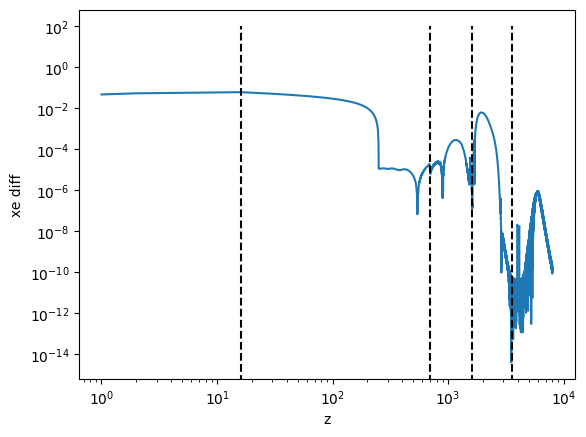

In [94]:
#plt.plot(z_hyrec, abs(xe_ABCMB-xe_hyrec)/xe_hyrec)
plt.plot(z_hyrec, abs(xe_ABC_interp(jnp.log(1/(1+z_hyrec)))-xe_hyrec)/xe_hyrec)

ax = plt.gca()
ax.vlines(3600,0,100,color='k',ls='dashed')
ax.vlines(1600,0,100,color='k',ls='dashed')
ax.vlines(700,0,100,color='k',ls='dashed')
ax.vlines(16,0,100,color='k',ls='dashed')
#plt.xlim((-9, -5))
#plt.ylim((1.e-12, 1))
plt.yscale("log")
plt.xscale("log")
plt.xlabel('z')
plt.ylabel('xe diff')
plt.show()

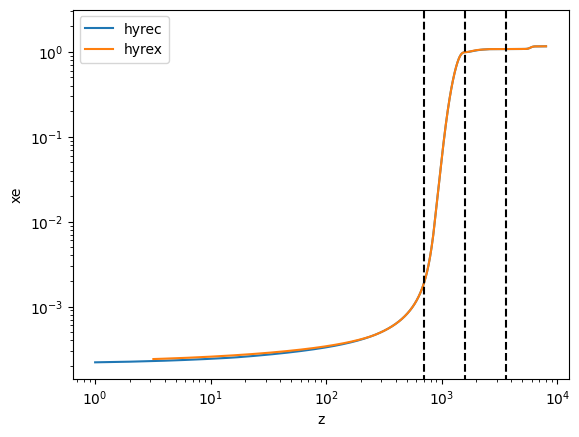

In [97]:
plt.loglog(z_hyrec,xe_hyrec,label='hyrec')
plt.loglog(jnp.exp(-lna)-1,xe_ABCMB,label='hyrex')

ax = plt.gca()
ax.vlines(3600,0,100,color='k',ls='dashed')
ax.vlines(1600,0,100,color='k',ls='dashed')
ax.vlines(700,0,100,color='k',ls='dashed')

# plt.xlim([2e3,2e4])
# plt.ylim([1,1.3])

plt.xlabel('z')
plt.ylabel('xe')

plt.legend()

In [100]:
print(model.species_list)

(DarkEnergy(), ColdDarkMatter(delta_idx=2), Baryon(
  delta_idx=3,
  photon=Photon(
    delta_idx=5,
    baryon=Baryon(delta_idx=3, photon=DarkEnergy()),
    num_F_ell_modes=7,
    num_G_ell_modes=7,
    num_ell_modes=14
  )
), Photon(
  delta_idx=5,
  baryon=Baryon(delta_idx=3, photon=DarkEnergy()),
  num_F_ell_modes=7,
  num_G_ell_modes=7,
  num_ell_modes=14
), MasslessNeutrinos(delta_idx=19))


In [99]:
jnp.exp(-BG.lna_xe_tab.lastval)

Array(4.19050735, dtype=float64)

Text(0, 0.5, 'Tm')

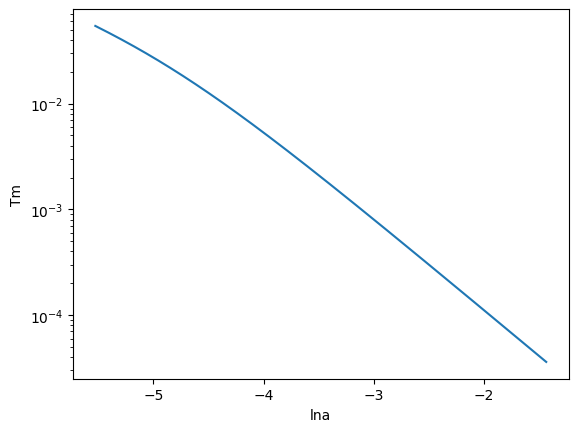

In [80]:
plt.plot(BG.lna_Tm_tab.arr[:BG.Tm_tab.lastnum],BG.Tm_tab.arr[:BG.Tm_tab.lastnum])
ax = plt.gca()
ax.set_yscale('log')
plt.xlabel('lna')
plt.ylabel('Tm')

# Saving Output

In [35]:
arr = np.array(list(params.items()), dtype=object)
np.savetxt("params.txt", arr, fmt="%s")
np.savez(
    "background.npz",
    tau_tab=np.array(BG.tau_tab),
    H_tab=np.array(BG.H(BG.lna_tau_tab)),
    xe_tab=np.array(BG.xe_tab.arr),
    lna_xe_tab=np.array(BG.lna_xe_tab.arr),
    Tm_tab=np.array(BG.Tm_tab.arr),
    lna_Tm_tab=np.array(BG.lna_Tm_tab.arr),
    kappa_tab=np.array(BG.kappa(BG.lna_tau_tab)),
)

# Comparing to CLASS

In [44]:
BG = cosmology.ClassBackground()

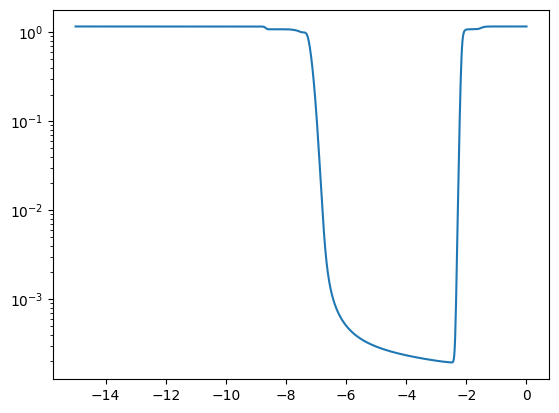

In [45]:
lna = jnp.linspace(-15.0, 0.0, 1000)
plt.plot(lna, BG.xe(lna))
plt.yscale("log")
plt.show()

In [46]:
path = "/home/zz1994/packages/class/output/ABCMB_test"
bg_class = np.loadtxt(path+"/noneutrinos00_background.dat")
thermo_class = np.loadtxt(path+"/noneutrinos00_thermodynamics.dat")

### Hubble

In [47]:
a = 1/(1.+bg_class[:, 0])
H_class = bg_class[:, 3] * cnst.c_Mpc_over_s
H_ABCMB = BG.H(jnp.log(a))

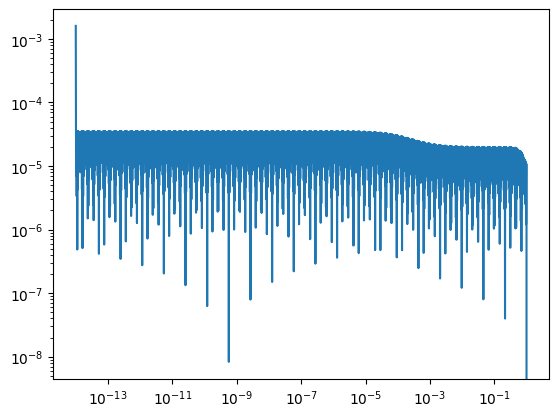

In [48]:
plt.loglog(a, abs(H_class - H_ABCMB)/H_class)
#plt.xlim((1.e-10, 0.))
plt.show()

### Conformal Time

In [49]:
a = 1/(1.+bg_class[:, 0])
tau_class = bg_class[:, 2]
tau_ABCMB = BG.tau(jnp.log(a))

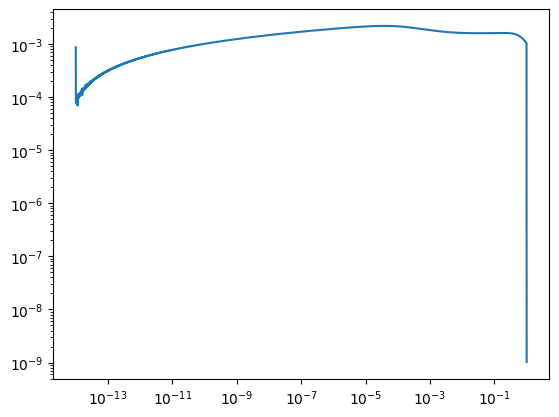

In [50]:
plt.loglog(a, abs(tau_class - tau_ABCMB)/tau_class)
#plt.xlim((1.e-10, 0.))
plt.show()

### xe, Tm

In [51]:
a = thermo_class[:, 0]
xe_class = thermo_class[:, 3]
Tm_class = thermo_class[:, 7]
xe_abcmb = BG.xe(jnp.log(a))
Tm_abcmb = BG.Tm(jnp.log(a)) / cnst.kB

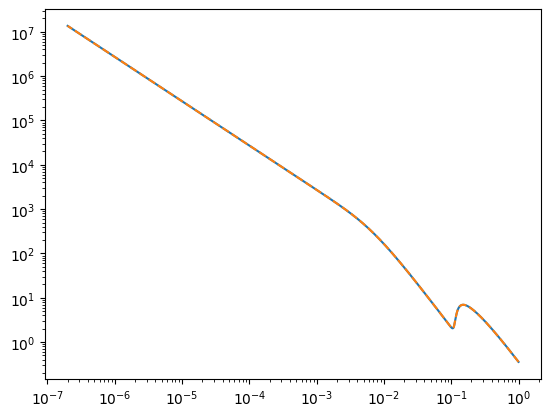

In [52]:
plt.loglog(a, Tm_class)
plt.loglog(a, Tm_abcmb, "--")
plt.show()

/state/partition1/job-296194/ipykernel_628462/4146330351.py:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


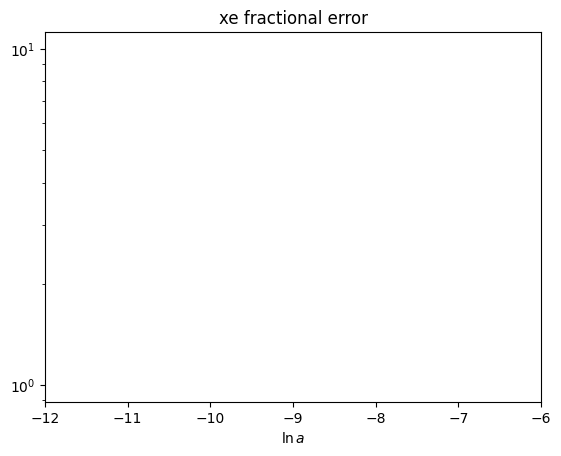

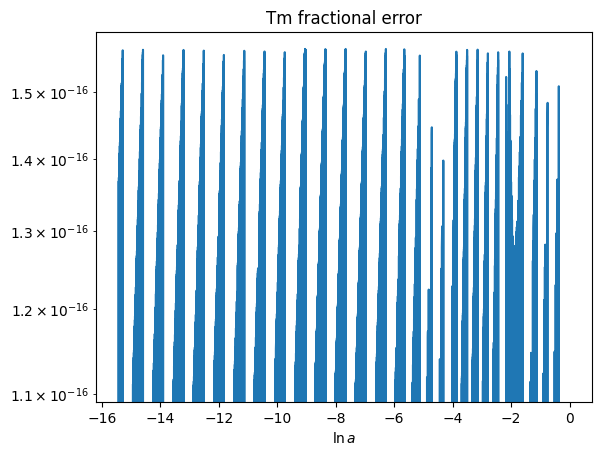

In [53]:
plt.plot(jnp.log(a), abs(xe_abcmb-xe_class)/xe_class)
plt.yscale("log")
plt.xlabel(r"$\ln{a}$")
plt.title("xe fractional error")
plt.xlim((-12, -6))
plt.show()

plt.plot(jnp.log(a), abs(Tm_abcmb-Tm_class)/Tm_class)
plt.yscale("log")
plt.xlabel(r"$\ln{a}$")
plt.title("Tm fractional error")
plt.show()

### Scattering Rate

In [54]:
a = thermo_class[:, 0]
tauc_class = 1/thermo_class[:, 4]
tauc_abcmb = BG.tau_c(jnp.log(a))

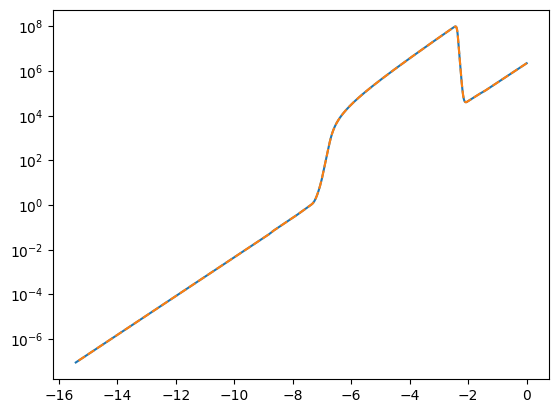

In [55]:
plt.plot(jnp.log(a), tauc_class)
plt.plot(jnp.log(a), tauc_abcmb, "--")
plt.yscale("log")
plt.show()

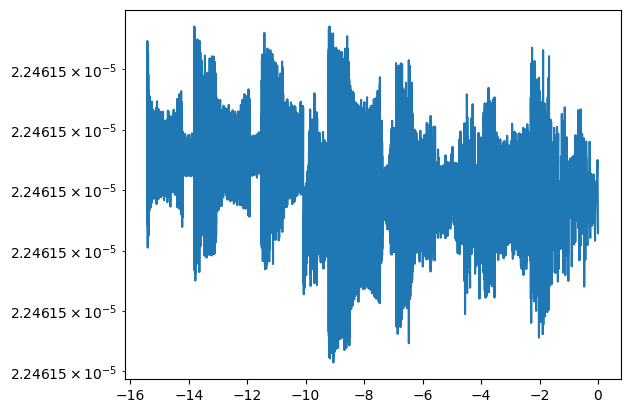

In [56]:
plt.plot(jnp.log(a), abs(tauc_abcmb-tauc_class)/tauc_class)
plt.yscale("log")
plt.show()

### Optical depth

In [57]:
a = thermo_class[:, 0]
kappa_class = -jnp.log(thermo_class[:, 5])
kappa_abcmb = BG.kappa(jnp.log(a))

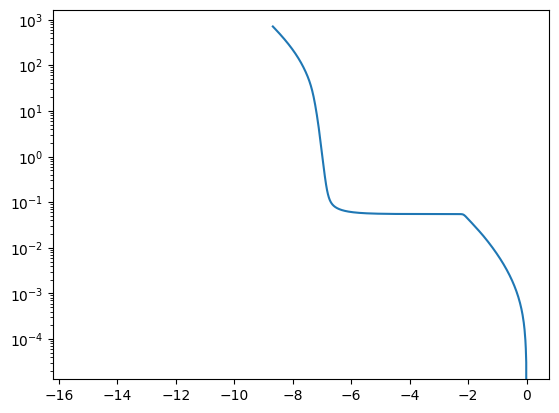

In [58]:
plt.plot(jnp.log(a), kappa_class)
plt.plot(jnp.log(a), kappa_abcmb, "--")
plt.yscale("log")
plt.show()

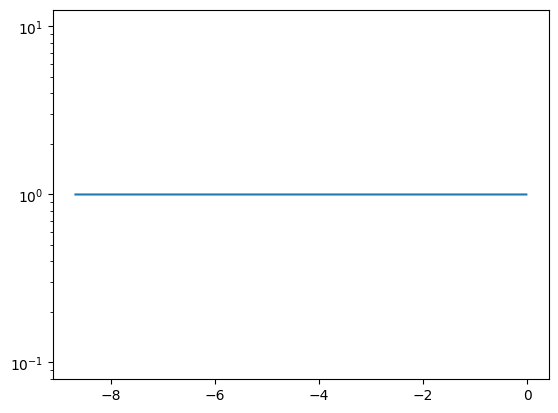

In [59]:
plt.plot(jnp.log(a), abs(kappa_abcmb-kappa_class)/kappa_class)
plt.yscale("log")
plt.show()

# Reading Result from CLASS

In [11]:
class_res_dir = "/home/zz1994/packages/class/output/ABCMB_test/noneutrinos00"
bac = np.loadtxt(class_res_dir+"_background.dat")
therm = np.loadtxt(class_res_dir+"_thermodynamics.dat")

In [13]:
bac[:, 4]

array([14248.53227261, 14248.53227261, 14248.53227261, ...,
          95.85369363,    47.79180017,     0.        ], shape=(3000,))

In [16]:
BG = cosmology.ClassBackground()

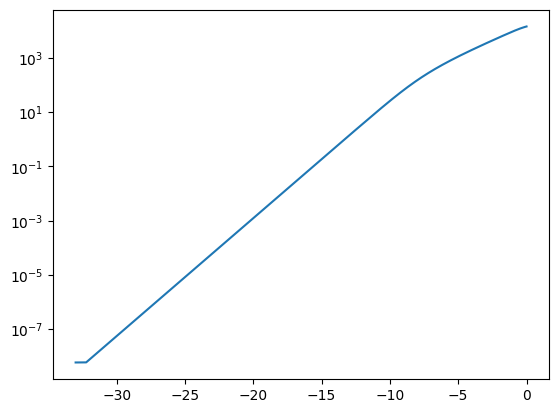

In [20]:
plt.plot(BG.lna_tau_tab, BG.tau_tab)
plt.yscale("log")

In [21]:
BG.params

{np.str_('h'): 0.6762,
 np.str_('omega_cdm'): 0.1193,
 np.str_('omega_b'): 0.0225,
 np.str_('A_s'): 2.12424e-09,
 np.str_('n_s'): 0.9709,
 np.str_('Neff'): 0.0,
 np.str_('YHe'): 0.245,
 np.str_('TCMB0'): 0.000234865418,
 np.str_('T_nu'): 0.00016763891600698252,
 np.str_('N_ncdm'): 0.0,
 np.str_('T_ncdm'): 0.00016818947448398,
 np.str_('m_ncdm'): 0.06,
 np.str_('omega_m'): 0.1418,
 np.str_('R_b'): 0.15867418899858954,
 np.str_('omega_g'): 2.4729742493571234e-05,
 np.str_('H0'): 2.191415436e-18,
 np.str_('N_ur'): 0.0,
 np.str_('omega_nu'): 0.0,
 np.str_('omega_r'): 2.4729742493571234e-05,
 np.str_('R_nu'): 0.0,
 np.str_('omega_Lambda'): 0.3154217102575064}

In [25]:
lna = jnp.log(therm[:, 0])
tau_c_class = 1./therm[:, 4]
tau_c_abcmb = BG.tau_c(lna)

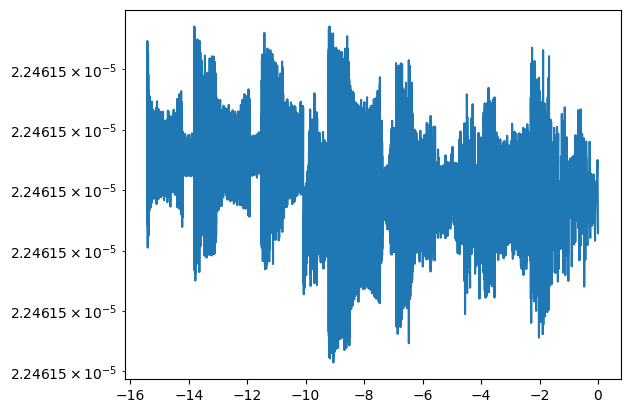

In [26]:
plt.plot(lna, abs(tau_c_class-tau_c_abcmb)/tau_c_class)
plt.yscale("log")
plt.show()